### Train optimizer
Notebook to train different optimizer to compare

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import os
import sys
import time
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm.notebook import trange, tqdm

In [3]:
# Run this cell only if you run this notebook on Google Colab.
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/Colab_Notebooks/OptiML/OptiForML2022')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from optimizer.AdaHessian import AdaHessian
from optimizer.Atmo import Atmo, MASScheduler
from optimizer.AdaSGD import AdaSGD
from dataset import ImagesDataset
from model import ResNet18
from path import TRAIN_HISTORY_DIR, TRAIN_MODEL_DIR

In [5]:
# choose dataset
#data_name = "MNIST"
data_name = "cifar"
full = True
tiny = False

# choose optimizer
optimizer_name = "adam"
optimizer_name = "sgd"
optimizer_name = "atmo"
optimizer_name = "dynamicAtom"
optimizer_name = "adaHessian"
optimizer_name = "adaSGD"

# choose scheduler
scheduler_name = None
#scheduler_name = "cosineAnnealinglr"
#scheduler_name = "steplr"
#scheduler_name = "multiSteplr"

# choose nb of epochs
#epochs = 160
if tiny:
  epochs = 50
else:
  epochs = 10

In [6]:
# load dataset
train_dataset = ImagesDataset(full = full, tiny=tiny, cifar=(data_name=="cifar"))
test_dataset = ImagesDataset(full = full, tiny=tiny, cifar=(data_name=="cifar"), test=True)


trainDataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)

* Using CIFAR
Files already downloaded and verified
** Use 50000 train samples
* Using CIFAR
Files already downloaded and verified
** Use 10000 test samples


In [7]:
# load model
model = ResNet18(in_channel=1 if data_name=="MNIST" else 3)
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)
model.train()
model.to(device)
#model.load_state_dict(torch.load(os.path.join(TRAIN_MODEL_DIR, f"{optimizer_name}_{scheduler_name}_{epochs}epochs_{data_name}.pt")))

# load optimizer
if optimizer_name == "adam":
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
if optimizer_name == "sgd":
    optimizer = optim.SGD(model.parameters(), lr=1e-3)
if optimizer_name == "atmo":
    optimizer = Atmo(model.parameters())
if optimizer_name == "dynamicAtom":
    optimizer = Atmo(model.parameters(), adam_w=1, sgd_w=0)
    dynamic = MASScheduler(optimizer, epochs = epochs)
if optimizer_name == "adaHessian":
    optimizer = AdaHessian(model.parameters(), lr = 0.0015)
if optimizer_name == "adaSGD":
    optimizer = AdaSGD(model.parameters(), lr = 0.1) 

# load scheduler
if scheduler_name is not None:
    if scheduler_name == "cosineAnnealinglr":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, verbose=True)
    if scheduler_name == "steplr":
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, verbose=True)
    if scheduler_name == "multiSteplr":
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [80, 120], gamma = 0.1, verbose = True)



criterion = nn.CrossEntropyLoss()
#with open(os.path.join(TRAIN_HISTORY_DIR, f"log-{optimizer_name}_{scheduler_name}_{epochs}epochs_{data_name}.pickle"), 'rb') as f:
#    history = pickle.load(f)

cuda


In [8]:
train_loss = []#history['train_loss']
train_acc = [] #history['train_acc']
test_loss = [] #history['test_loss']
test_acc = []  #history['test_acc']
time_epoch = [] #history['time_epoch']
epochs_done = 1 #len(train_loss)

with trange(epochs_done, epochs + 1, desc='Training', unit='epoch') as t:
  for epoch in t:
    losses = []
    acc = []
    start_time = time.time()
    with tqdm(trainDataLoader, desc=f'Train epoch {epoch}',
              unit='batch', leave=False) as t1:
      for x_train, y_train in t1:
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        optimizer.zero_grad()
        output = model(x_train)
        loss = criterion(output, y_train)
        loss.backward(create_graph=(optimizer_name=="adaHessian" or optimizer_name == 'adaSGD'))
        optimizer.step()

        losses.append(loss)
        pred = torch.argmax(output, axis = 1)
        acc.append(sum(pred == y_train).item()/pred.shape[0])

    if optimizer_name=="dynamicAtmo":
          dynamic.step()

    train_loss.append(sum(losses)/len(losses))
    train_acc.append(sum(acc)/len(acc))

    losses = []
    acc = []
    with torch.no_grad():
      with tqdm(testDataLoader, desc=f'Test epoch {epoch}',
                unit='batch', leave=False) as t1:
        for x_test, y_test in t1:
          x_test = x_test.to(device)
          y_test = y_test.to(device)

          output = model(x_test)
          loss = criterion(output, y_test)
          losses.append(loss)

          pred = torch.argmax(output, axis = 1)
          acc.append(sum(pred == y_test).item()/pred.shape[0])

      test_loss.append(sum(losses)/len(losses))
      test_acc.append(sum(acc)/len(acc))

      end_time = time.time()
      time_epoch.append(end_time-start_time)
    if scheduler_name is not None:
          scheduler.step()
    history = dict()
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["test_loss"] = test_loss
    history["test_acc"] = test_acc
    history["time_epoch"] = time_epoch
    history["data"] = data_name
    history["model"] = "resnet18"
    history["epochs"] = epochs
    history["optimizer"] = optimizer_name
    #with open(os.path.join(TRAIN_HISTORY_DIR, f"log-{optimizer_name}_{scheduler_name}_{epochs}epochs_{data_name}.pickle"), 'wb') as f:
    #  pickle.dump(history, f)
    #weights = model.state_dict()
    #torch.save(weights,os.path.join(TRAIN_MODEL_DIR, f"{optimizer_name}_{scheduler_name}_{epochs}epochs_{data_name}.pt"))
#mean by epoch
time_epoch = sum(time_epoch)/len(time_epoch)

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Train epoch 1:   0%|          | 0/196 [00:00<?, ?batch/s]

/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at  ../torch/csrc/autograd/engine.cpp:985.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


Test epoch 1:   0%|          | 0/40 [00:00<?, ?batch/s]

Train epoch 2:   0%|          | 0/196 [00:00<?, ?batch/s]

Test epoch 2:   0%|          | 0/40 [00:00<?, ?batch/s]

Train epoch 3:   0%|          | 0/196 [00:00<?, ?batch/s]

Test epoch 3:   0%|          | 0/40 [00:00<?, ?batch/s]

Train epoch 4:   0%|          | 0/196 [00:00<?, ?batch/s]

Test epoch 4:   0%|          | 0/40 [00:00<?, ?batch/s]

Train epoch 5:   0%|          | 0/196 [00:00<?, ?batch/s]

Test epoch 5:   0%|          | 0/40 [00:00<?, ?batch/s]

Train epoch 6:   0%|          | 0/196 [00:00<?, ?batch/s]

Test epoch 6:   0%|          | 0/40 [00:00<?, ?batch/s]

Train epoch 7:   0%|          | 0/196 [00:00<?, ?batch/s]

Test epoch 7:   0%|          | 0/40 [00:00<?, ?batch/s]

Train epoch 8:   0%|          | 0/196 [00:00<?, ?batch/s]

Test epoch 8:   0%|          | 0/40 [00:00<?, ?batch/s]

Train epoch 9:   0%|          | 0/196 [00:00<?, ?batch/s]

Test epoch 9:   0%|          | 0/40 [00:00<?, ?batch/s]

Train epoch 10:   0%|          | 0/196 [00:00<?, ?batch/s]

Test epoch 10:   0%|          | 0/40 [00:00<?, ?batch/s]

In [9]:
print(history['train_acc'])

[0.1765266262755102, 0.3281847895408163, 0.41904097576530613, 0.49001514668367346, 0.554085618622449, 0.6166334502551021, 0.6683872767857143, 0.7077208227040817, 0.7456433354591837, 0.7783442283163264]


In [10]:
# run this cell to save history
history = dict()
history["train_loss"] = train_loss
history["train_acc"] = train_acc
history["test_loss"] = test_loss
history["test_acc"] = test_acc
history["time_epoch"] = time_epoch
history["data"] = data_name
history["model"] = "resnet18"
history["epochs"] = epochs
history["optimizer"] = optimizer_name
#with open(os.path.join(TRAIN_HISTORY_DIR, f"log-{optimizer_name}_{epochs}epochs_{data_name}.pickle"), 'wb') as f:
#  pickle.dump(history, f)

In [11]:
# run this cell to save model
#weights = model.state_dict()
#torch.save(weights,os.path.join(TRAIN_MODEL_DIR, f"{optimizer_name}_{epochs}epochs_{data_name}.pt"))

TypeError: ignored

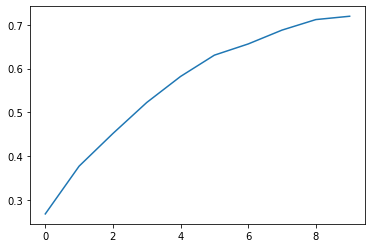

In [12]:
import matplotlib.pyplot as plt
plt.plot(test_acc, label = 'test acc')
plt.plot(test_loss, label = 'test loss')
plt.plot(train_acc, label = 'train acc')
plt.plot(test_acc, label = 'test acc')
plt.legend()